Répartition des classes dans l'ensemble de données :
drug_type
2    22396
1     7812
0      212
Name: count, dtype: int64


c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\subprocess.py", line 1036, 


--- Random Forest ---
Accuracy : 0.9339250493096647
Rapport de classification :
              precision    recall  f1-score   support

    ADDITIVE       0.69      0.95      0.80        44
        BASE       0.81      0.98      0.89      1583
        MAIN       0.99      0.92      0.95      4457

    accuracy                           0.93      6084
   macro avg       0.83      0.95      0.88      6084
weighted avg       0.94      0.93      0.94      6084



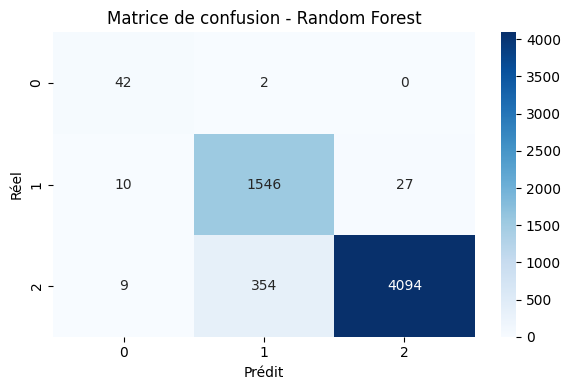


--- Logistic Regression ---
Accuracy : 0.6193293885601578
Rapport de classification :
              precision    recall  f1-score   support

    ADDITIVE       0.06      0.93      0.12        44
        BASE       0.45      0.88      0.60      1583
        MAIN       0.99      0.52      0.68      4457

    accuracy                           0.62      6084
   macro avg       0.50      0.78      0.47      6084
weighted avg       0.85      0.62      0.66      6084



c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


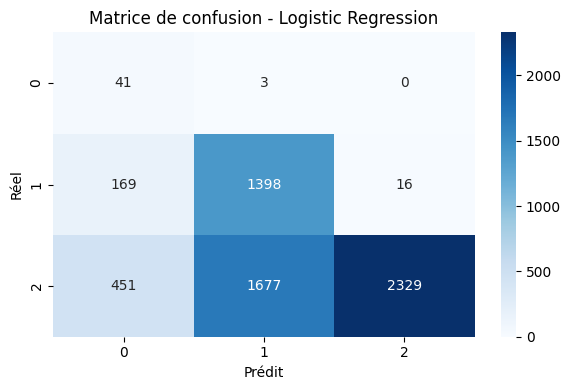

c:\Users\LENOVO\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:56:09] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "scale_pos_weight", "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
Accuracy : 0.9224194608809994
Rapport de classification :
              precision    recall  f1-score   support

    ADDITIVE       0.67      0.95      0.79        44
        BASE       0.79      0.98      0.87      1583
        MAIN       0.99      0.90      0.95      4457

    accuracy                           0.92      6084
   macro avg       0.81      0.94      0.87      6084
weighted avg       0.94      0.92      0.93      6084



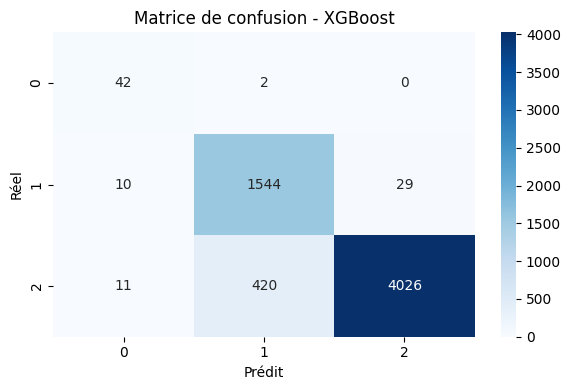


🎯 Résumé des précisions :
Random Forest      : 93.39%
Logistic Regression: 61.93%
XGBoost            : 92.24%

✅ Le modèle le plus performant est : **Random Forest**

Le modèle et le label_map ont été sauvegardés avec succès.


In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from imblearn.over_sampling import SMOTE  # SMOTE pour sur-échantillonnage
from sklearn.utils.class_weight import compute_class_weight

# Connexion PostgreSQL
USERNAME = os.getenv("POSTGRES_USER", "postgres")
PASSWORD = os.getenv("POSTGRES_PASSWORD", "123456789")
HOST = os.getenv("POSTGRES_HOST", "localhost")
PORT = os.getenv("POSTGRES_PORT", "5432")
DATABASE = os.getenv("POSTGRES_DB", "DBM")

DATABASE_URL = f"postgresql+psycopg2://{USERNAME}:{PASSWORD}@{HOST}:{PORT}/{DATABASE}"
engine = create_engine(DATABASE_URL, connect_args={'client_encoding': 'LATIN1'})

# Chargement des données
treatment = pd.read_sql('SELECT * FROM "Dim_Treatment"', engine)
patients = pd.read_sql('SELECT * FROM "Dim_Patient"', engine)

# Traitement de la date de naissance
patients['date_of_birth'] = pd.to_datetime(patients['date_of_birth'], errors='coerce')

# Fusion
df = treatment.merge(patients, on="hadm_id", how="left")

# Nettoyage dose_val_rx
def parse_range(val):
    try:
        val = str(val)
        if '-' in val:
            parts = val.split('-')
            return (float(parts[0]) + float(parts[1])) / 2
        return float(val)
    except:
        return None

df['dose_val_rx'] = df['dose_val_rx'].apply(parse_range)

# Sélection des colonnes utiles
features = ['dose_val_rx', 'route', 'Gender',  'Weight', 'Bmi']
df = df[features + ['drug_type']].dropna()

# Encodage des variables catégorielles
df = pd.get_dummies(df, columns=['route', 'Gender'], drop_first=True)

# Encodage de la cible
df['drug_type'] = df['drug_type'].astype('category')
label_map = dict(enumerate(df['drug_type'].cat.categories))
df['drug_type'] = df['drug_type'].cat.codes

# Nettoyage des virgules
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = df[col].str.replace(",", ".", regex=False)
        try:
            df[col] = df[col].astype(float)
        except:
            pass

# Vérification de l'équilibre des classes
print("Répartition des classes dans l'ensemble de données :")
print(df['drug_type'].value_counts())

# Séparation
X = df.drop("drug_type", axis=1)
y = df["drug_type"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Appliquer SMOTE pour le sur-échantillonnage des classes minoritaires
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# === Fonction d'évaluation ===
def evaluate_model(model, model_name):
    y_pred = model.predict(X_test)
    print(f"\n--- {model_name} ---")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Rapport de classification :")
    print(classification_report(y_test, y_pred, target_names=list(label_map.values())))
    plt.figure(figsize=(6, 4))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.show()
    return accuracy_score(y_test, y_pred)

# === Modèle 1: Random Forest ===
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf.fit(X_train_smote, y_train_smote)
acc_rf = evaluate_model(rf, "Random Forest")

# === Modèle 2: Logistic Regression ===
lr = LogisticRegression(max_iter=1000, class_weight='balanced')
lr.fit(X_train_smote, y_train_smote)
acc_lr = evaluate_model(lr, "Logistic Regression")

# === Modèle 3: XGBoost ===
xgb = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42, scale_pos_weight=1.0)
xgb.fit(X_train_smote, y_train_smote)
acc_xgb = evaluate_model(xgb, "XGBoost")

# === Résumé des résultats ===
print("\n🎯 Résumé des précisions :")
print(f"Random Forest      : {acc_rf:.2%}")
print(f"Logistic Regression: {acc_lr:.2%}")
print(f"XGBoost            : {acc_xgb:.2%}")

# Meilleur modèle
best_model_name = max(
    [("Random Forest", acc_rf), ("Logistic Regression", acc_lr), ("XGBoost", acc_xgb)],
    key=lambda x: x[1]
)[0]

print(f"\n✅ Le modèle le plus performant est : **{best_model_name}**")

# Sauvegarder le meilleur modèle
best_model = rf if best_model_name == "Random Forest" else lr if best_model_name == "Logistic Regression" else xgb
joblib.dump(best_model, 'drug_prediction_model.pkl')

# Sauvegarder aussi le label_map pour décoder plus tard
joblib.dump(label_map, 'label_map.pkl')

# Sauvegarde du modèle
print("\nLe modèle et le label_map ont été sauvegardés avec succès.")
